### Import, pickle and comparison of proteomes

In [1]:
%matplotlib inline
import os.path
import pandas as pd
import cPickle as pkl
import csv
import xlrd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

datadir = "../data"

Consensus proteome according to Pax-DB (http://pax-db.org/dao/4932-WHOLE_ORGANISM-integrated.txt):

In [3]:
prot_paxdb_file = '4932-S.cerevisiae_whole_organism-integrated_dataset.txt'
prot_paxdb_path = os.path.join(datadir, prot_paxdb_file)

with open(prot_paxdb_path, mode='r') as infile:
    lines = infile.readlines()[9:]
    lines = [(line.split()[1], line.split()[2]) for line in lines]
    prot_paxdb = dict((line[0].split('.')[1], float(line[1])) for line in lines)

In [4]:
pd.Series(prot_paxdb).describe()

count     6159.000000
mean       162.364020
std        843.292868
min          0.000303
25%          1.759430
50%         10.582627
75%         53.385761
max      24556.397666
dtype: float64

Proteome according to Brockmann (http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.0030057#s5):

In [7]:
prot_brockmann_file = 'journal.pcbi.0030057.st001.XLS'
prot_brockmann_path = os.path.join(datadir, prot_brockmann_file)

workbook = xlrd.open_workbook(prot_brockmann_path)
worksheet = workbook.sheet_by_name('Table S1')
num_rows = worksheet.nrows - 1
num_cells = worksheet.ncols - 1
curr_row = 0 # First row contains headers hence not -1
prot_brockmann = {}

for curr_row in range(worksheet.nrows)[1:]:
    row = worksheet.row(curr_row)
    if isinstance(row[13].value, float):
        prot_brockmann[row[0].value] = row[13].value

In [8]:
pd.Series(prot_brockmann).describe()

count       4186.000000
mean        8546.981370
std        32580.366689
min           41.100000
25%         1211.711000
50%         2721.796000
75%         6753.983437
max      1589836.911000
dtype: float64

Spectral counting proteome according to Pax-DB (http://pax-db.org/dao/4932-PA_201303.txt):

In [53]:
prot_paxdb2013_file = '4932-PA_201303.txt'
prot_paxdb2013_path = os.path.join(datadir, prot_paxdb2012_file)

with open(prot_paxdb2012_path, mode='r') as infile:
    lines = infile.readlines()[11:]
    lines = [(line.split()[1], line.split()[2]) for line in lines]
    prot_paxdb2013 = dict((line[0].split('.')[1], float(line[1])) for line in lines)

In [54]:
pd.Series(prot_paxdb2013).describe()

count     4828.000000
mean       207.122702
std       1011.158411
min          0.011000
25%          2.247500
50%         11.300000
75%         56.650000
max      28416.000000
dtype: float64

In [55]:
def scatter_dicts(dict1, dict2):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

4180


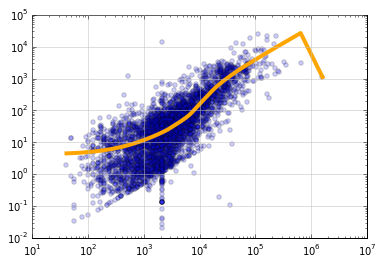

In [56]:
scatter_dicts(prot_brockmann, prot_paxdb)

In [57]:
df1 = pd.DataFrame.from_dict(prot_brockmann.items())
df1.columns = ['name', 'n_brockmann']

df2 = pd.DataFrame.from_dict(prot_paxdb.items())
df2.columns = ['name', 'n_paxdb']

df3 = pd.DataFrame.from_dict(prot_paxdb2013.items())
df3.columns = ['name', 'n_paxdb_2013']

Build full outer join of the data frames:

In [61]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')

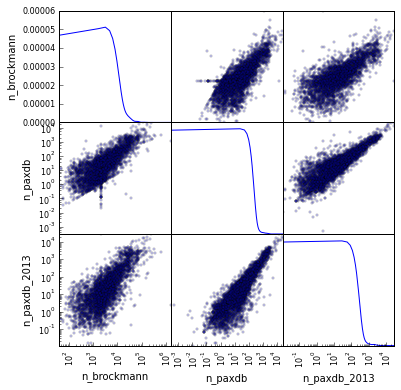

In [62]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(6, 6), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([df[df.columns[j+1]].min(), df[df.columns[j+1]].max()]) 
            ax.set_ylim([df[df.columns[i+1]].min(), df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([df[df.columns[j+1]].min(), df[df.columns[j+1]].max()])
            ax.set_xscale('log')            